# Logistic Regression for Sentiment Analysis

Adapted from http://nbviewer.jupyter.org/github/rasbt/pattern_classification/blob/master/machine_learning/scikit-learn/outofcore_modelpersistence.ipynb

<br>
<br>

## The IMDb Movie Review Dataset

In this section, we will train a simple logistic regression model to classify movie reviews from the 50k IMDb review dataset that has been collected by Maas et. al.

> AL Maas, RE Daly, PT Pham, D Huang, AY Ng, and C Potts. Learning word vectors for sentiment analysis. In Proceedings of the 49th Annual Meeting of the Association for Computational Lin- guistics: Human Language Technologies, pages 142–150, Portland, Oregon, USA, June 2011. Association for Computational Linguistics

[Source: http://ai.stanford.edu/~amaas/data/sentiment/]

The dataset consists of 50,000 movie reviews from the original "train" and "test" subdirectories. The class labels are binary (1=positive and 0=negative) and contain 25,000 positive and 25,000 negative movie reviews, respectively.
For simplicity, I assembled the reviews in a single CSV file.


In [1]:
import pandas as pd
# if you want to download the original file:
#df = pd.read_csv('https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/50k_imdb_movie_reviews.csv')
# otherwise load local file
#df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)
df = pd.read_csv('shuffled_movie_data.csv')
df.tail()

,review,sentiment
49995,"I've expected a comedy about the NVA, but this...",0
49996,Jamie Foxx was the epitome of Ray Charles. Aft...,1
49997,The last couple of weeks in the life of a dead...,0
49998,"(No need to recap the plot, since others have ...",1
49999,The movie starts quite with an intriguing scen...,0


Let us shuffle the class labels.

In [2]:
import numpy as np
## uncomment these lines if you have dowloaded the original file:
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df[['review', 'sentiment']].to_csv('shuffled_movie_data.csv', index=False)
df.head()

,review,sentiment
11841,Not worth the video rental or the time or the ...,0
19602,I would recommend this for anyone who is an ad...,1
45519,This film is about two female killers going on...,0
25747,The film is a pathetic attempt to remake Ingma...,0
42642,What a trip down memory lane.<br /><br />Do no...,1


<br>
<br>

## Preprocessing Text Data

Now, let us define a simple `tokenizer` that splits the text into individual word tokens. Furthermore, we will use some simple regular expression to remove HTML markup and all non-letter characters but "emoticons," convert the text to lower case, remove stopwords, and apply the Porter stemming algorithm to convert the words into their root form.

In [3]:
import numpy as np
# from nltk.stem.porter import PorterStemmer
import re
import sys
import time
# import nltk
# nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()

def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text = [w for w in text.split()]
    tokenized = [wordnet_lemmatizer.lemmatize(w) for w in text]
    return tokenized

Let's give it at try:

In [4]:
tokenizer('This :) is a <a> test! :-)</br>')

['this', 'is', 'a', 'test']

## Learning (SciKit)

First, we define a generator that returns the document body and the corresponding class label:

In [5]:
def stream_docs(path):
    with open(path, 'r', encoding="utf8") as csv:
        next(csv) # skip header
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label

To conform that the `stream_docs` function fetches the documents as intended, let us execute the following code snippet before we implement the `get_minibatch` function:

In [6]:
next(stream_docs(path='shuffled_movie_data.csv'))

('"Not worth the video rental or the time or the occasional efforts.<br /><br />*Makeup that a child can do. *Acting was over done...poor directing. *Editing was very choppy...many things made no sense or just seemed gratuitous. *Sound was badly dubbed. *Music was highly inappropriate. *Casting was extremely off...must have been on crack. *Zombies that talk let alone...drive, dance, work...just pisses me off. *And the bad guy...Holy Crap! As horribly casted as he was...he was the best looking zombie of all. Which doesn\'t say much.<br /><br />The Cover Art was good but very deceiving...as was the Main Menu of the DVD...great artwork and music.<br /><br />DON""T BOTHER!"',
 0)

After we confirmed that our `stream_docs` functions works, we will now implement a `get_minibatch` function to fetch a specified number (`size`) of documents:

In [7]:
def get_minibatch(doc_stream, size):
    docs, y = [], []
    for _ in range(size):
        text, label = next(doc_stream)
        docs.append(text)
        y.append(label)
    return np.array(docs), np.array(y)

In [8]:
# !pip install gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

doc_generator = stream_docs(path='shuffled_movie_data.csv')

sentences = []
labels    = []
lengths   = []
for idx, review in enumerate(doc_generator):
    toVec = tokenizer(review[0])
    sentences.append(toVec)
    labels.append(review[1])
    lengths.append(len(toVec))
    sys.stdout.write('\r{:5.2f}%'.format(100*(idx+1)/50000))
sys.stdout.write('\rDone     \n\n')  
print(len(sentences))

Done     

50000


In [9]:
emb_size = 40
model = Word2Vec(sentences, size=emb_size, window=5, min_count=5, workers=4)
print('trained!')

trained!


In [10]:
sim = model.wv.most_similar(positive=['woman'], topn=1)
print("'woman' is similar to '{}' with a score of {:1.4f}".format(sim[0][0],sim[0][1]))

'woman' is similar to 'girl' with a score of 0.8721


/home/dpalominop/anaconda3/envs/SI/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [11]:
print('vocabulary size :', len(model.wv.vocab.keys()))

vocabulary size : 35327


In [12]:
print('embedding size : ', model.wv['woman'].shape)

embedding size :  (40,)


In [13]:
class ReviewVectorizer:
    def __init__(self, model, maxlen):
        self.model  = model
        self.maxlen = maxlen
    def transform(self, reviews_tokenized):
        n = len(reviews_tokenized)
        vector = np.zeros((n, self.maxlen, emb_size), dtype=np.float16)
        for idx, review in enumerate(reviews_tokenized):
            for iw, word in enumerate(review):
                if word in self.model.wv.vocab:
                    vector[idx][iw] = self.model.wv[word]
            sys.stdout.write('\r{:5.2f}%'.format(100*(idx+1)/n))
        sys.stdout.write('\rDone     \n\n')                    
        vector = vector.reshape((n, -1))
        return vector

In [14]:
MAXLEN = max(lengths)
vectorizer = ReviewVectorizer(model, MAXLEN)

In [15]:
res = vectorizer.transform(sentences)
assert (MAXLEN*emb_size == res.shape[1])

y_train = np.asarray(labels).reshape((-1, 1))
X_train = res
del res

Done     



Next, we will make use of the "hashing trick" through scikit-learns [HashingVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html) to create a bag-of-words model of our documents. Details of the bag-of-words model for document classification can be found at  [Naive Bayes and Text Classification I - Introduction and Theory](http://arxiv.org/abs/1410.5329).

Using the [SGDClassifier]() from scikit-learn, we will can instanciate a logistic regression classifier that learns from the documents incrementally using stochastic gradient descent. 

Red Neuronal de 3 capas:

In [16]:
D = X_train.shape[1]
K = 2

# Numero de neuronas por capas
nn_layer_0 = D
nn_layer_1 = 200
nn_layer_2 = 200
nn_layer_3 = K

def initialize_parameters(nn_input_dim, nn_hdim, nn_output_dim):
    # First layer weights
    np.random.seed(0)
    mu, sigma = 0, 0.1
    
    W1 = np.random.normal(mu, sigma, (nn_hdim, nn_input_dim))
#     W1 = np.zeros((nn_input_dim, nn_hdim_1))
    
    # First layer bias
#     b1 = np.random.normal(mu, sigma, (nn_hdim_1, 1))
    b1 = np.zeros((nn_hdim, 1))
    
    # Second layer weights
    W2 = np.random.normal(mu, sigma, (nn_hdim, nn_hdim))
#     W2 = np.zeros((nn_hdim_1, nn_hdim_2))
    
    # Second layer bias
#     b2 = np.random.normal(mu, sigma, (nn_hdim_2, 1))
    b2 = np.zeros((nn_hdim, 1))
    
    # Thirs layer weights
    W3 = np.random.normal(mu, sigma, (nn_output_dim, nn_hdim))
#     W3 = np.zeros((nn_hdim_2, nn_output_dim))
    
    # Second layer bias
#     b3 = np.random.normal(mu, sigma, (nn_output_dim, 1))
    b3 = np.zeros((nn_output_dim, 1))
    
    
    # Package and return model
    model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return model

Non Linear function for hidden layers:

In [17]:
def relu(x):
    return np.maximum(x, 0)

In [18]:
def relu_deriv(x):
    x[x<=0] = 0.0
    x[x>0] = 1.0
    return x

Non Linear function for output layers:

Softmax:

In [19]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1/(1.0+np.exp(-z))
    return s

In [20]:
def sigmoid_deriv(z):
    """
    Compute the derivative of the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid_deriv(z)
    """
    s = sigmoid(z)*(1-sigmoid(z))
    return s

loss function for binary classification:

In [21]:
def compute_cost(y, y_hat):
    m = y.shape[1]
    L = 1/m*np.sum(0.5*(y-y_hat)*(y-y_hat))
    return L

Gradient calculation:

In [22]:
def propagate_two_layer(W1, b1, W2, b2, W3, b3, X, y, use_reg=False, reg_lambda=0.01):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    W -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dW -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[0]
    num_examples = X.shape[0]
    A0 = X.T
    Z1 = np.dot(W1, A0)+b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1)+b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2)+b3
    A3 = sigmoid(Z3)
    
    cost = compute_cost(y.T, y_hat=A3)

    if use_reg:
        reg_cost = 0.5 * reg_lambda * np.sum(W1*W1) + 0.5 * reg_lambda * np.sum(W2*W2) + 0.5 * reg_lambda * np.sum(W3*W3)
        cost = cost + reg_cost

    dz3 = (A3-y.T)*sigmoid_deriv(Z3)

    dW3 = np.dot(dz3, A2.T)/m
    db3 = np.sum(dz3, axis=1)[:, np.newaxis]/m
    
    dz2 = np.dot(W3.T, dz3)*relu_deriv(Z2)
    dW2 = np.dot(dz2, A1.T)/m
    db2 = np.sum(dz2, axis=1)[:, np.newaxis]/m

    dz1 = np.dot(W2.T, dz2)*relu_deriv(Z1)
    dW1 = np.dot(dz1, A0.T)/m
    db1 = np.sum(dz1, axis=1)[:, np.newaxis]/m
    
    if use_reg:
        dW1 += reg_lambda*W1
        dW2 += reg_lambda*W2
        dW3 += reg_lambda*W3

    assert(dW1.shape == W1.shape)
    assert(db1.dtype == float)
    assert(dW2.shape == W2.shape)
    assert(db2.dtype == float)
    assert(dW3.shape == W3.shape)
    assert(db3.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3}
    
    return grads, cost

Update weigths:

In [23]:
def optimize_two_layer(W1, b1, W2, b2, W3, b3, X, y, num_iterations, learning_rate, use_reg = False, reg_lambda = 0.01, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    use_reg -- use regularization
    reg_lambda -- regularization weight
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    cost_i = 0
    for ii in range(num_iterations):
        
        grads, cost = propagate_two_layer(W1, b1, W2, b2, W3, b3, X, y, use_reg=use_reg, reg_lambda=reg_lambda)

        dW1 = grads["dW1"]
        db1 = grads["db1"]
        dW2 = grads["dW2"]
        db2 = grads["db2"]
        dW3 = grads["dW3"]
        db3 = grads["db3"]
        
        W1 = W1 - learning_rate*dW1
        b1 = b1 - learning_rate*db1
        W2 = W2 - learning_rate*dW2
        b2 = b2 - learning_rate*db2
        W3 = W3 - learning_rate*dW3
        b3 = b3 - learning_rate*db3
        
        if ii % 100 == 0:
            costs.append(cost)
            cost_i += 1
        
        # Print the cost every 100 training iterations
        if print_cost and ii % 100 == 0:
            print ("Cost after iteration %i: %f" %(ii, cost))
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2,
             "dW3": dW3,
             "db3": db3}
    
    return params, grads, costs

Prediction:

In [24]:
def predict_two_layer(W1, b1, W2, b2, W3, b3, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[0]
    Y_prediction = np.zeros((1,m))

    A0 = X.T
    A1 = relu(np.dot(W1, A0)+b1)
    A2 = relu(np.dot(W2, A1)+b2)
    A3 = sigmoid(np.dot(W3, A2)+b3)
    
    for ii in range(A3.shape[1]):

        if(A3[0, ii] > 0.5):
            Y_prediction[0, ii] = 1
        else:
            Y_prediction[0, ii] = 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

Training:

In [25]:
def train_three_layer(X_train, y_train, K=2, h_neurons=100, num_iterations=2000, learning_rate=0.5, use_reg=False, reg_lambda=0.01, init_type='random', print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    Y_prediction_train = 0
    costs_list = []
    accuracies = []
    model = initialize_parameters(D, h_neurons, K)
    W1, b1, W2, b2, W3, b3 = model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']

    for i in range(10):
        X_train_batch = X_train[(i*5000):((i+1)*5000),:]
        y_train_batch = y_train[(i*5000):((i+1)*5000)]

        parameters, grads, costs = optimize_two_layer(W1, b1, W2, b2, W3, b3, X_train_batch, y_train_batch, num_iterations, learning_rate, use_reg = use_reg, reg_lambda = reg_lambda, print_cost = print_cost)
        costs_list.append(costs)
        
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        W3 = parameters["W3"]
        b3 = parameters["b3"]

        Y_prediction_train = predict_two_layer(W1, b1, W2, b2, W3, b3, X_train_batch)

        print('training accuracy: %.2f' % (np.mean(Y_prediction_train == y_train_batch.T)))
        
        accuracies.append(np.mean(Y_prediction_train == y_train_batch.T))
    
    d = {"costs": costs_list,
         "W1" : W1, 
         "b1" : b1,
         "W2" : W2, 
         "b2" : b2,
         "W3" : W3, 
         "b3" : b3,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations,
         "accuracies": accuracies}
    
    return d

## Training the three layers:

In [26]:
%xmode Plain
%pdb on
d = train_three_layer(X_train, y_train, K=1,  h_neurons=20, num_iterations=500, learning_rate= 1, use_reg=True, reg_lambda=1e-3, print_cost=True)

Exception reporting mode: Plain
Automatic pdb calling has been turned ON
Cost after iteration 0: 10.121762
Cost after iteration 100: 8.270106
Cost after iteration 200: 6.723809
Cost after iteration 300: 5.493990
Cost after iteration 400: 4.497370
training accuracy: 0.99
Cost after iteration 0: 3.855530
Cost after iteration 100: 3.032361
Cost after iteration 200: 2.480789
Cost after iteration 300: 2.032177
Cost after iteration 400: 1.665798
training accuracy: 0.99
Cost after iteration 0: 1.512892
Cost after iteration 100: 1.118684
Cost after iteration 200: 0.916159
Cost after iteration 300: 0.751006
Cost after iteration 400: 0.615871
training accuracy: 1.00
Cost after iteration 0: 0.623370
Cost after iteration 100: 0.502369
Cost after iteration 200: 0.441562
Cost after iteration 300: 0.377349
Cost after iteration 400: 0.250986
training accuracy: 1.00
Cost after iteration 0: 0.312409
Cost after iteration 100: 0.209098
Cost after iteration 200: 0.152531
Cost after iteration 300: 0.122561


## Prediction of last 5 000 phrases:

In [27]:
Y_prediction_train = predict_two_layer(d["W1"], d["b1"], d["W2"], d["b2"], d["W3"], d["b3"], X_train[45000:50000,:])
print('training accuracy: %.2f' % (np.mean(Y_prediction_train == y_train[45000:50000].T)))

training accuracy: 1.00


Depending on your machine, it will take about 2-3 minutes to stream the documents and learn the weights for the logistic regression model to classify "new" movie reviews. Executing the preceding code, we used the first 45,000 movie reviews to train the classifier, which means that we have 5,000 reviews left for testing:

## Graphics of Cost vs Iterations over each batch

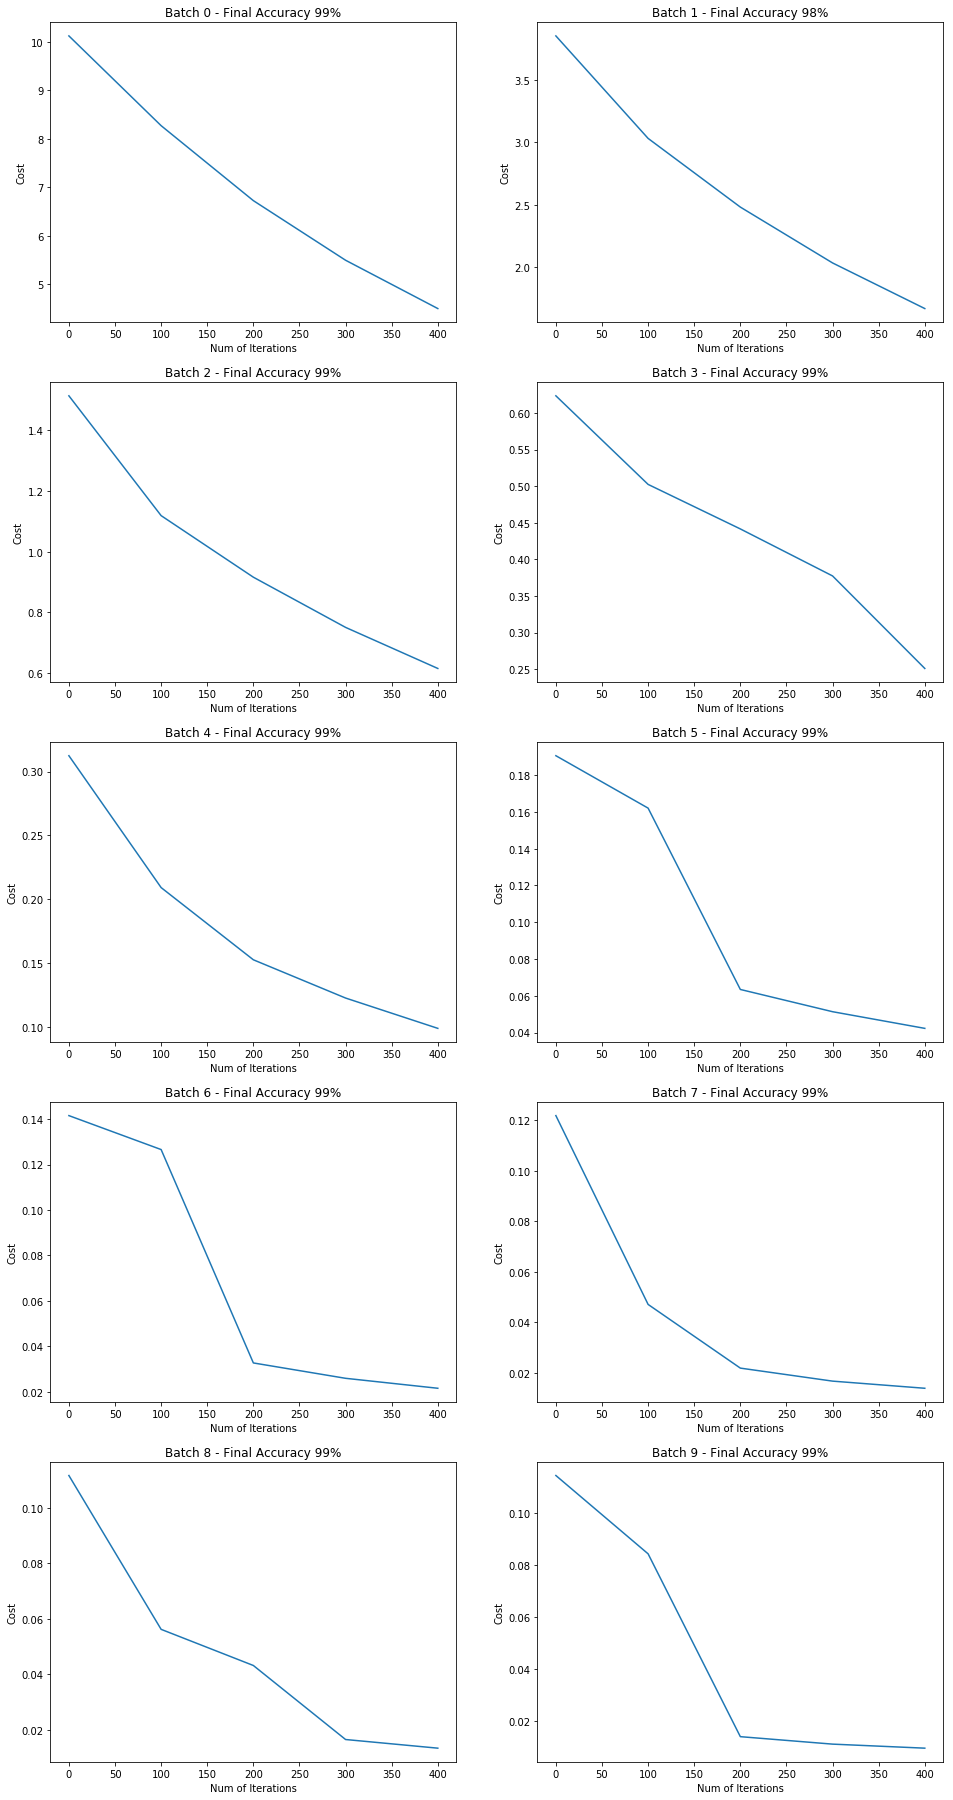

In [28]:
plt.figure(figsize=(16, 32))
for i, other in enumerate(d['costs']):
    plt.subplot(5, 2, i+1)
    
    cost    = d['costs'][i]
    iteration = [c*100 for c in range(len(cost))]
    accuracy  = d['accuracies'][i]*100
    
    plt.title('Batch %d - Final Accuracy %d%%' % (i, accuracy))
    plt.xlabel('Num of Iterations')
    plt.ylabel('Cost')
    
    plt.plot(iteration, cost)
plt.show()

<br>
<br>